In [1]:
import warnings
# 경고 무시하기
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from scipy import stats


from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, make_scorer, mean_squared_error, mean_absolute_error
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge, HuberRegressor, Lasso
from xgboost import XGBRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor

# SimpleImputer는 이 라인을 유지합니다
from sklearn.impute import SimpleImputer

In [4]:
input_data = pd.read_csv("2023_smartFarm_AI_hackathon_dataset.csv")
labels = input_data[['outtrn_cumsum', 'HeatingEnergyUsage_cumsum']]

In [5]:
input_data['date'] = pd.to_datetime(input_data['date'], format='%Y%m%d')

In [6]:
encoder = LabelEncoder()
input_data['frmDist'] = encoder.fit_transform(input_data['frmDist'])

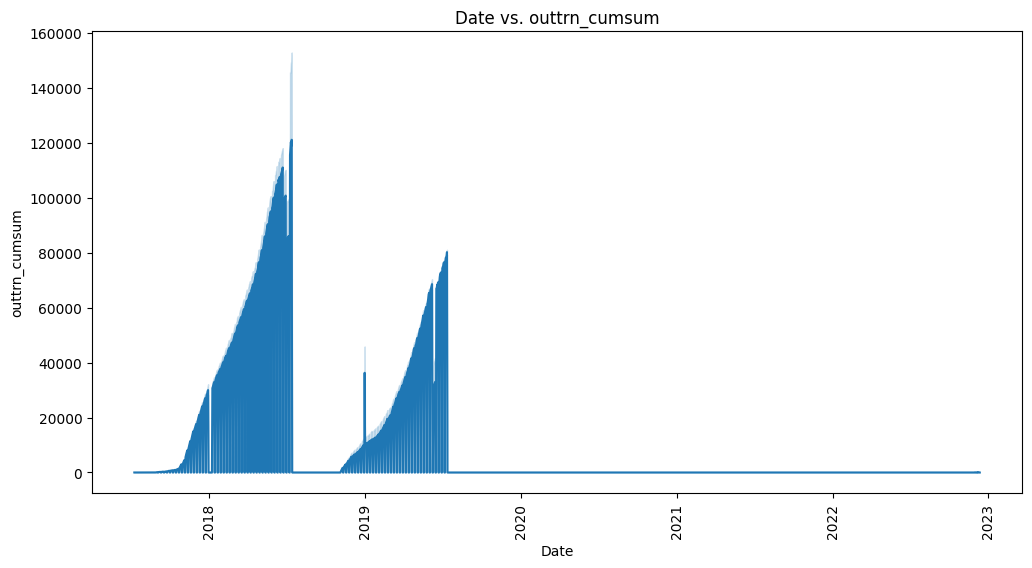

In [7]:
# 그래프 크기 설정
plt.figure(figsize=(12, 6))

# 선 그래프 그리기
sns.lineplot(data=input_data, x='date', y='outtrn_cumsum')

# x축 레이블 및 제목 설정
plt.xlabel('Date')
plt.ylabel('outtrn_cumsum')
plt.title('Date vs. outtrn_cumsum')

# x축 눈금 라벨을 90도 회전하여 가독성 향상
plt.xticks(rotation=90)

# 그래프 표시
plt.show()

In [8]:
# # outtrn_cumsum 이랑 HeatingEnergyUsage_cumsum은 역방향 관계임

# sorted_data = input_data.groupby('frmDist').mean().reset_index()
# sorted_data = sorted_data.sort_values(by=['outtrn_cumsum', 'HeatingEnergyUsage_cumsum'], ascending=False)
# sorted_data

In [9]:
input_data["year"] = input_data["date"].dt.year
input_data["month"] = input_data["date"].dt.month
input_data["day"] = input_data["date"].dt.day

In [10]:
input_data.drop(['date'], axis=1, inplace=True)

In [11]:
scaler = MinMaxScaler()
input_data = scaler.fit_transform(input_data)

In [12]:
input_data = np.log(input_data)
labels = np.log(labels)

input_data[input_data == -np.inf] = 0
input_data[input_data == np.inf] = 0
labels[labels == np.inf] = 0
labels[labels == -np.inf] = 0

C:\Users\INTEL WIN11PRO(12TH)\AppData\Local\Temp\ipykernel_19744\3235272276.py:1: RuntimeWarning: divide by zero encountered in log
  input_data = np.log(input_data)
C:\Users\INTEL WIN11PRO(12TH)\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [13]:
train = input_data[:42420]
test = input_data[42420:]

In [14]:
pca= PCA()
pca.fit(train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
dim = np.argmax(cumsum >= 0.90) + 1
print('The number of dimensions required to preserve 90% of variance is',dim)

The number of dimensions required to preserve 90% of variance is 14


In [15]:
pca_components = pca.components_
for i, component in enumerate(pca_components[:14]):
    print(f"Component {i+1}: {component}")

Component 1: [-3.79266369e-02  9.52315428e-02  3.95592309e-02  2.00653451e-01
  9.39318844e-02  3.75595327e-01  4.53855714e-02  1.27612033e-03
  1.87320916e-01 -5.29395592e-23  5.42532815e-02  2.41388727e-01
  4.27838276e-05  1.52721228e-01  2.21883029e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.21526838e-01  1.23088442e-01
  0.00000000e+00 -4.25211545e-03  2.15642748e-01  2.55971225e-01
  0.00000000e+00  4.07648469e-01  2.08333369e-01  7.18960761e-02
  0.00000000e+00  4.68040895e-02  1.10068512e-01  0.00000000e+00
  9.37228081e-02  9.86333554e-02  1.31267574e-01  3.82159699e-02
  2.18619785e-01 -1.18277921e-01 -1.18277921e-01 -9.78817653e-02
 -9.78817653e-02 -3.78261690e-02 -3.78261690e-02 -1.69545390e-01
 -1.69545390e-01 -9.96067897e-02  1.03851793e-01  8.76523732e-02
 -2.54784901e-02]
Component 2: [-1.94256776e-02  3.20432150e-02  2.92064132e-02  1.46332591e-01
  4.48947088e-02  1.78422115e-01  8.71567033e-03 -5.46165387e-02
  1.37031912e-01  1.35525272e-20  8.66050909e-

In [16]:
pca = PCA(n_components=14, whiten=True)
pca = pca.fit(input_data)
dataPCA = pca.transform(input_data)

In [17]:
dataPCA.shape

(84840, 14)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(dataPCA, labels, test_size = 0.3, random_state = 0)

In [21]:
xgb_regr = xgb.XGBRegressor( #just arbitrary xgboost
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    nthread=3,
    scale_pos_weight=1,
    seed=1
    )

In [22]:
xgb_regr.fit(X_train, y_train)
xgb_pred = xgb_regr.predict(X_test)

r2 = r2_score(y_test, xgb_pred)
print("R-squared (R2) Score:", r2)

rmse = np.sqrt(np.mean((y_test - xgb_pred)**2))
print("Root Mean Squared Error (RMSE):", rmse)


R-squared (R2) Score: 0.9893016173131404
Root Mean Squared Error (RMSE): outtrn_cumsum                0.352855
HeatingEnergyUsage_cumsum    0.510539
dtype: float64


In [23]:
xgb2_regr = xgb.XGBRegressor(
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=13,
    min_child_weight=7,
    gamma=0,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='reg:squarederror',
    nthread=3,
    scale_pos_weight=1,
    reg_alpha=50,
    reg_lambda=0.05,
    seed=1
    )
xgb2_regr.fit(X_train, y_train)
xgb_pred2 = xgb2_regr.predict(X_test)


r2 = r2_score(y_test, xgb_pred)
print("R-squared (R2) Score:", r2)

rmse = np.sqrt(np.mean((y_test - xgb_pred)**2))
print("Root Mean Squared Error (RMSE):", rmse)


R-squared (R2) Score: 0.9893016173131404
Root Mean Squared Error (RMSE): outtrn_cumsum                0.352855
HeatingEnergyUsage_cumsum    0.510539
dtype: float64
